Mounting Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Necessary Libraries

In [3]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score , accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler

A convention followed to check if cuda toolkit is present in the system or not. Although I don't have Cuda toolkit to train my model on GPU I have written this (a good practice)

In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The following cell is the path to my dataset

In [5]:
dataset_path = '/content/drive/MyDrive/Spinach_Dataset'

Transformations applied to the dataset for training data as well as validation data

In [6]:
# Define the transformations for augmented data (training set)
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Splitting the dataset into Training, Validation , Testing

In [7]:
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Paths to datasets
augmented_data_path = '/content/drive/MyDrive/Spinach_Dataset/Augmented Dataset'
original_data_path = '/content/drive/MyDrive/Spinach_Dataset/Original Dataset'

# Load datasets
augmented_dataset = datasets.ImageFolder(augmented_data_path, transform=train_transform)
original_dataset = datasets.ImageFolder(original_data_path, transform=val_transform)

# Split original dataset into three parts: training, validation, testing
orig_indices = list(range(len(original_dataset)))
train_indices, val_test_indices = train_test_split(orig_indices, test_size=2/3, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

# Create subsets
original_train_dataset = Subset(original_dataset, train_indices)  # 33.33% of original dataset for training
val_dataset = Subset(original_dataset, val_indices)              # 33.33% of original dataset for validation
test_dataset = Subset(original_dataset, test_indices)            # 33.33% of original dataset for testing

# Combine augmented dataset with the 33.33% of original for training
combined_train_dataset = ConcatDataset([augmented_dataset, original_train_dataset])

# Data loaders
batch_size = 32

train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for confirmation
print(f"Training set size (Augmented + Original(33.33%)): {len(combined_train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size (Augmented + Original(33.33%)): 6008
Validation set size: 201
Test set size: 201


Hyperparameters defined.

In [7]:
# Hyperparameters
batch_size = 32
num_epochs = 5
learning_rate = 0.001

Creating ResNET50 Model architecture

In [8]:
# Define the ResNet-50 model for classification
from torchvision import models

# Define the ResNet-50 model for classification
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Classifier, self).__init__()
        # Load ResNet-50 model without pretrained weights
        self.resnet = models.resnet50(weights=None)  # Set weights=None to avoid loading pretrained weights
        self.resnet.fc = nn.Linear(2048, num_classes)  # Modify for 3 classes

    def forward(self, x):
        return self.resnet(x)  # Forward pass through the ResNet model

Installing tqdm which shows us the progress bar during training

In [9]:
pip install tqdm

Calling our defined model ResNet50Classifier by passing the the output layer as I want to classify between 3 classes(Anthracnose,Algal leaf, Healthy)
Model=model.to(device) ... This line moves the model to my local device for training.

In [10]:
model = ResNet50Classifier(num_classes=3)
model = model.to(device)


Defining the Loss function(i.e, cross entropy loss).. and optimization algorithm (Adam-this uses Stochastic gradient descent algorithm for optimization)

In [11]:
# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Initializing Loss function and Optimizer and initializing arrays for storing the training losses,validation loss , etc.

In [12]:
# Training and Validation Function
def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    # Initialize Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track metrics
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = []
    precision_scores, recall_scores, f1_scores = [], [], []

Training the model for classification under tqdm progress bar , which helps in visualizing the progress in training. Here the model will be trained for 5 epochs. The model will process a batch of 32 samples from the dataset simultaneously.

In [13]:
from tqdm import tqdm
# Initialize metrics
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [] , []
precision_scores, recall_scores, f1_scores = [], [], []
#  training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # tqdm progress bar
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Update tqdm description
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Training statistics
    train_loss.append(epoch_loss / len(train_loader))
    train_accuracy.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_epoch_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Validation metrics
    val_loss.append(val_epoch_loss / len(val_loader))
    val_accuracy.append(100 * correct_val / total_val)
    precision_scores.append(precision_score(all_labels, all_preds, average='weighted', zero_division=0))
    recall_scores.append(recall_score(all_labels, all_preds, average='weighted',  zero_division=0))
    f1_scores.append(f1_score(all_labels, all_preds, average='weighted',  zero_division=0))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%")



Epoch 1/5, Train Loss: 0.8842, Val Loss: 1.1406, Val Accuracy: 62.69%


Epoch 2/5, Train Loss: 0.6030, Val Loss: 0.7054, Val Accuracy: 68.16%


Epoch 3/5, Train Loss: 0.5322, Val Loss: 0.9578, Val Accuracy: 60.20%


Epoch 4/5, Train Loss: 0.4754, Val Loss: 0.7895, Val Accuracy: 65.67%


Epoch 5/5, Train Loss: 0.4051, Val Loss: 0.4541, Val Accuracy: 82.09%


Plotting the results

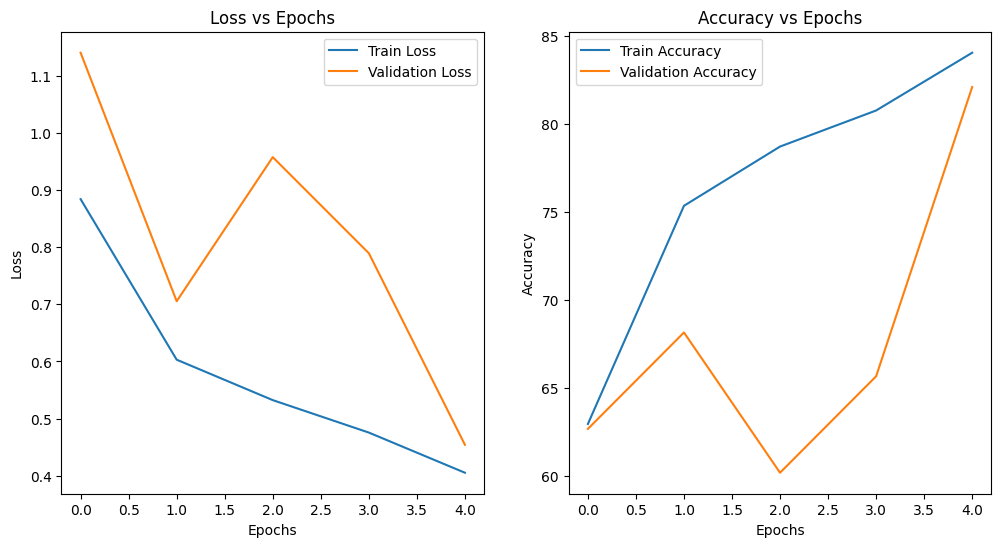

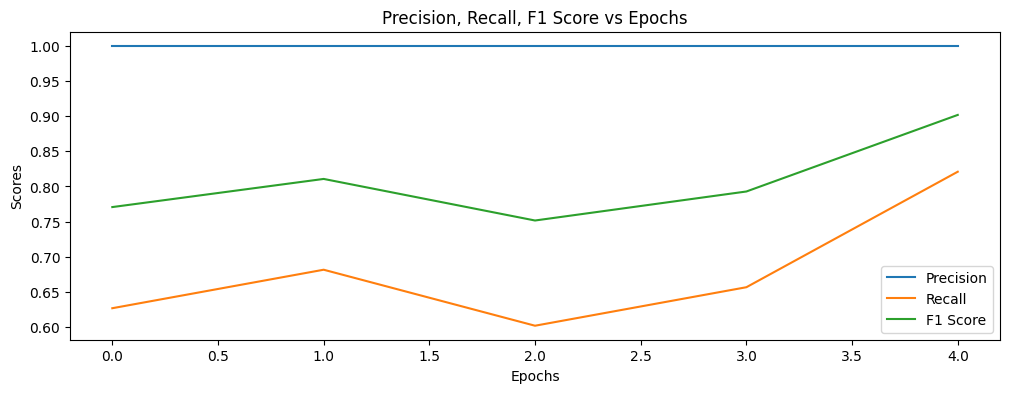

In [14]:
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision, recall, f1):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(12, 4))
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(f1, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, F1 Score vs Epochs')
    plt.legend()
    plt.show()

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision_scores, recall_scores, f1_scores)



Saving the model weights in .pth file extension. These model weights can be loaded later for predicting from the learned weights .

In [15]:
# Save the model's state_dict (weights)
torch.save(model.state_dict(), 'resnet50_Spinach_Weights.pth')


saving the model weights as resnet50_Spinach_Weights in my google drive. This will help me upload into github directly from google drive.

In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Spinach_Dataset/resnet50_Spinach_Weights.pth')


Loading the model later with the help of prelearned weights for testing.

In [9]:
import torch
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Assuming your model class is defined as 'ResNet50Classifier'
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(weights=None)  # weights=None to avoid loading pretrained weights, Weights are set to none as I don't want predefined weights of RESNET50 rather I want my own trained weights.
        self.resnet.fc = nn.Linear(2048, num_classes)  #  for 3 classes

    def forward(self, x):
        return self.resnet(x)

# Load the model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=3)  # Adjust num_classes based on your dataset
model.load_state_dict(torch.load('/content/drive/MyDrive/Spinach_Dataset/resnet50_Spinach_Weights.pth'))  # Load the saved model weights
model.to(device)  # Move model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode

<ipython-input-9-888abd66a71e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Spinach_Dataset/resnet50_Spinach_We

ResNet50Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


Finding the testing accuracy.. which came out to be 81.59%

In [10]:
# Define the DataLoader for the test set (assuming you've already prepared it)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
all_labels = []
all_preds = []

with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Collecting all labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 81.59%


Plotting the confusion matrix and classification report 

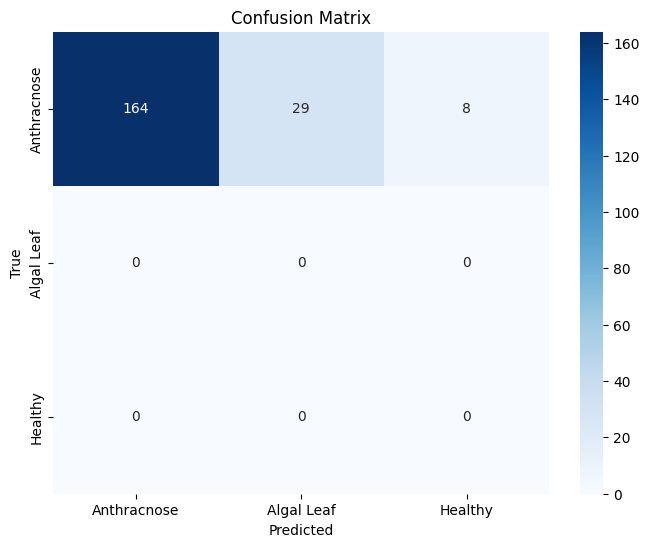

              precision    recall  f1-score   support

 Anthracnose       1.00      0.82      0.90       201
  Algal Leaf       0.00      0.00      0.00         0
     Healthy       0.00      0.00      0.00         0

    accuracy                           0.82       201
   macro avg       0.33      0.27      0.30       201
weighted avg       1.00      0.82      0.90       201



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Anthracnose', 'Algal Leaf', 'Healthy'], yticklabels=['Anthracnose', 'Algal Leaf', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=['Anthracnose', 'Algal Leaf', 'Healthy'])
print(report)
